# Importing the necessary libraries

In [1]:
import os
import cv2
import sys
import numpy as np
from keras.optimizers import SGD
import matplotlib.pyplot as plot
from keras.utils import load_img,img_to_array,array_to_img
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D,Flatten,MaxPooling2D,Dense
from keras.models import Sequential
import glob,os,random
from keras.applications.resnet import ResNet,ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.resnet_v2 import ResNet152V2
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.optimizers import Adam
from keras.layers import Dense, Flatten, Dropout
from numpy.random.mtrand import shuffle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import pathlib
import PIL
import time
import zipfile
import random
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.metrics import confusion_matrix


In [5]:
train_path ='train_dataset/train'
test_path ='test_dataset/test'

classes = os.listdir(train_path)
num_classes = len(classes)

height,width = 32,32
batch_size = 32
split = 0.2

In [7]:
#checking the number of test image counts
images = glob.glob(os.path.join(test_path,"*/*.jpg"))
print(len(images))

324


# Image Preprocessing

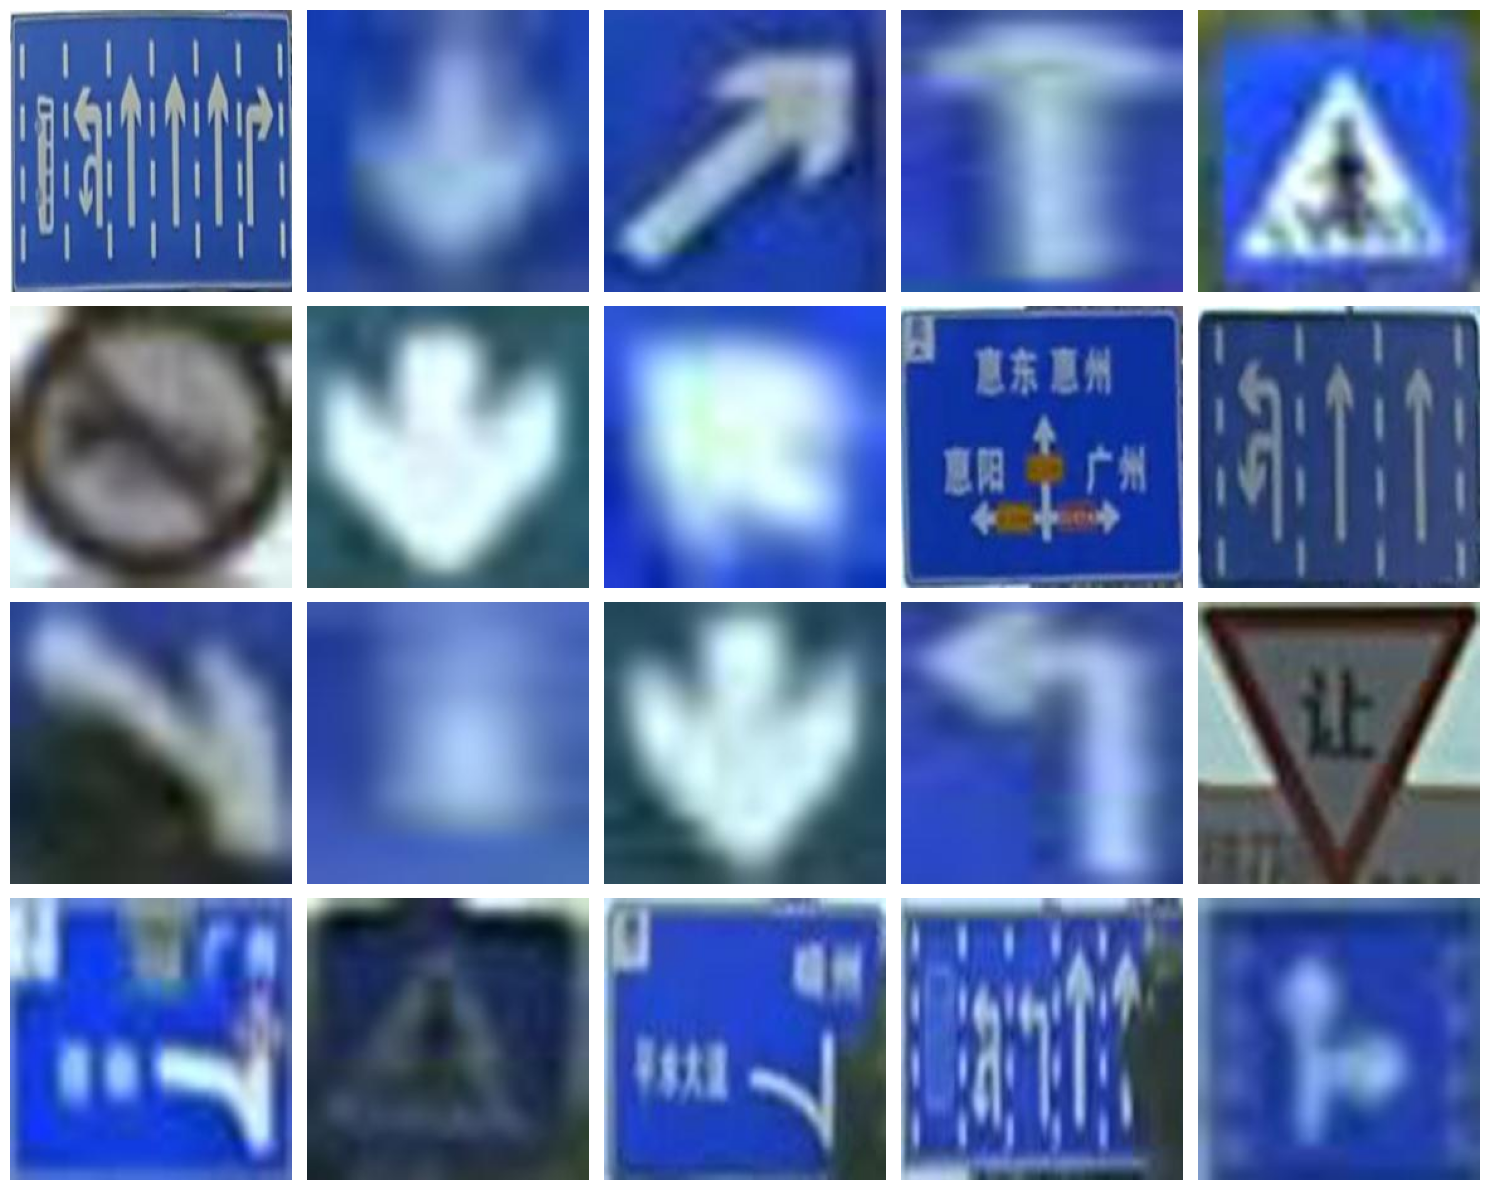

In [8]:
# Generate random test images to display
num_images_to_display = 20
random_images = random.sample(images, num_images_to_display)

# Set up subplots for display
rows = 4
columns = 5
plt.figure(figsize=(15, 12))

for index, imageFilePath in enumerate(random_images):
    image = load_img(imageFilePath)
    image_array = img_to_array(image, dtype=np.uint8)

    plt.subplot(rows, columns, index + 1)
    plt.imshow(image_array.squeeze())
    plt.axis('off')  # Turn off axes for cleaner display

plt.tight_layout()
plt.show()

In [9]:
classes

['GuideSign', 'M1', 'M4', 'M5', 'M6', 'M7', 'P1', 'P10_50', 'P12', 'W1']

## Building the model

In [10]:
# Data augmentation for training dataset
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=20,          # Random rotation up to 20 degrees
    horizontal_flip=True,       # Randomly flip images horizontally
    validation_split=split)     # Split for training and validation subsets

# Create a training data generator
train_ds = train_datagen.flow_from_directory(
    train_path,                  # Path to the main directory containing subdirectories of classes
    target_size=(height,width),# Target size for resizing images
    batch_size=batch_size,      # Number of images in each batch
    subset="training",          # Use the training subset
    class_mode="categorical",   # Categorical labels for multi-class classification
    shuffle=True                # Shuffle the dataset for each epoch
)

# Create a validation data generator
val_ds = train_datagen.flow_from_directory(
    train_path,                  # Same main directory as above
    target_size=(height,width),
    batch_size=batch_size,
    subset="validation",        # Use the validation subset
    class_mode="categorical",
    shuffle=False               # No need to shuffle validation data
)

# Data augmentation for testing dataset (only rescaling)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)

# Create a test data generator
test_ds = test_datagen.flow_from_directory(
    test_path,                  # Path to the directory containing test images
    target_size=(height,width),
    shuffle=True                # Shuffle the test dataset
)


Found 4823 images belonging to 10 classes.
Found 1201 images belonging to 10 classes.
Found 324 images belonging to 10 classes.


## Sequential Model

In [11]:
# Create a Sequential model
model = Sequential([
    # Layer 1: Convolutional and MaxPooling
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu',
           input_shape=(32, 32, 3)),         # Input shape for images: 32x32x3 (RGB)
    MaxPooling2D(pool_size=2),              # MaxPooling to reduce spatial dimensions
    
    # Layer 2: Convolutional and MaxPooling
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    # Layer 3: Convolutional and MaxPooling
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    # Layer 4: Convolutional and MaxPooling
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(pool_size=2),
    
    # Flatten to transition to fully connected layers
    Flatten(),
    
    # Fully connected layer 1
    Dense(64, activation="relu"),
    
    # Fully connected layer 2 (output layer)
    Dense(10, activation="softmax")          # 10 classes for multi-class classification
])

# Print model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

## Model Optimizers

In [12]:
# Compile the model
model.compile(
    optimizer=Adam(lr=0.0001),                 # Adam optimizer with learning rate
    loss='categorical_crossentropy',          # Categorical cross-entropy loss for multi-class classification
    metrics=['accuracy']                      # Evaluation metric: accuracy
)


## Model Checkpoint

In [13]:
# Define a ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath="./best_weights_fit.h5",                 # Filepath to save the best model weights
    monitor='val_accuracy',                   # Metric to monitor for improvement
    verbose=1,                                # Verbosity level: 1 for progress updates
    save_best_only=True                       # Save only the best model checkpoint
)

# Create a list of custom callbacks
custom_callbacks = [checkpoint]

## Fitting the Model

In [14]:
# Fit the model to the training data
result = model.fit(
    train_ds,                                 # Training data generator
    epochs=10,                                # Number of epochs for training
    validation_data=val_ds,                   # Validation data generator
    callbacks=custom_callbacks                # Custom callbacks, including ModelCheckpoint
)


Epoch 1/10
151/151 [==============================] - ETA: 0s - loss: 1.7659 - accuracy: 0.5115
Epoch 1: val_accuracy improved from -inf to 0.53372, saving model to .\best_weights_fit.h5
151/151 [==============================] - 154s 1s/step - loss: 1.7659 - accuracy: 0.5115 - val_loss: 1.4592 - val_accuracy: 0.5337
Epoch 2/10
151/151 [==============================] - ETA: 0s - loss: 1.2871 - accuracy: 0.5743
Epoch 2: val_accuracy improved from 0.53372 to 0.67194, saving model to .\best_weights_fit.h5
151/151 [==============================] - 25s 167ms/step - loss: 1.2871 - accuracy: 0.5743 - val_loss: 1.1380 - val_accuracy: 0.6719
Epoch 3/10
151/151 [==============================] - ETA: 0s - loss: 1.0181 - accuracy: 0.6894
Epoch 3: val_accuracy improved from 0.67194 to 0.74355, saving model to .\best_weights_fit.h5
151/151 [==============================] - 25s 167ms/step - loss: 1.0181 - accuracy: 0.6894 - val_loss: 0.8620 - val_accuracy: 0.7435
Epoch 4/10
151/151 [=============

In [15]:
# Evaluate the model on the test dataset
test_evaluation = model.evaluate(test_ds)

11/11 [==============================] - 5s 455ms/step - loss: 0.4728 - accuracy: 0.8642


## Visualisation

In [18]:
def loss_graph(header, result):
    # Create a figure for plotting
    fig = plt.figure(dpi=150, figsize=(10, 7))
    ax1 = fig.add_subplot(221)

    # Plot training loss and validation loss
    ax1.plot(result.history['loss'], label='train_loss')
    ax1.plot(result.history['val_loss'], label='val_loss')
    ax1.legend(loc='center right')

    # Add labels and title to the plot
    fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
    fig.text(0.03, 0.5, 'loss', ha='center', va='center', rotation='vertical')
    ax1.set_title(header)

    # Display the plot
    plt.show()


In [19]:
def accuracy_graph(header, result):
    # Create a figure for plotting
    fig = plt.figure(dpi=150, figsize=(10, 7))
    ax1 = fig.add_subplot(221)

    # Plot training accuracy and validation accuracy
    ax1.plot(result.history['accuracy'], label='train_accuracy')
    ax1.plot(result.history['val_accuracy'], label='val_accuracy')
    ax1.legend(loc='center right')

    # Add labels and title to the plot
    fig.text(0.5, 0.04, 'epoch', ha='center', va='center')
    fig.text(0.03, 0.5, 'accuracy', ha='center', va='center', rotation='vertical')
    ax1.set_title(header)

    # Display the plot
    plt.show()


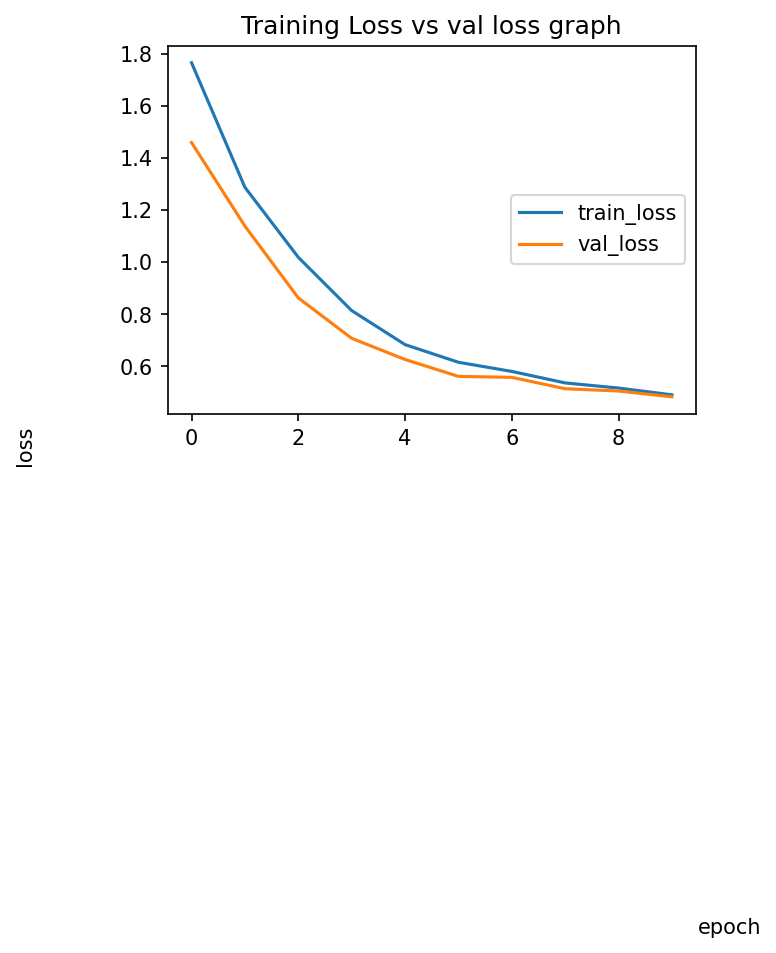

In [20]:
# Call the loss_graph function to visualize training and validation loss
loss_graph("Training Loss vs val loss graph", result)

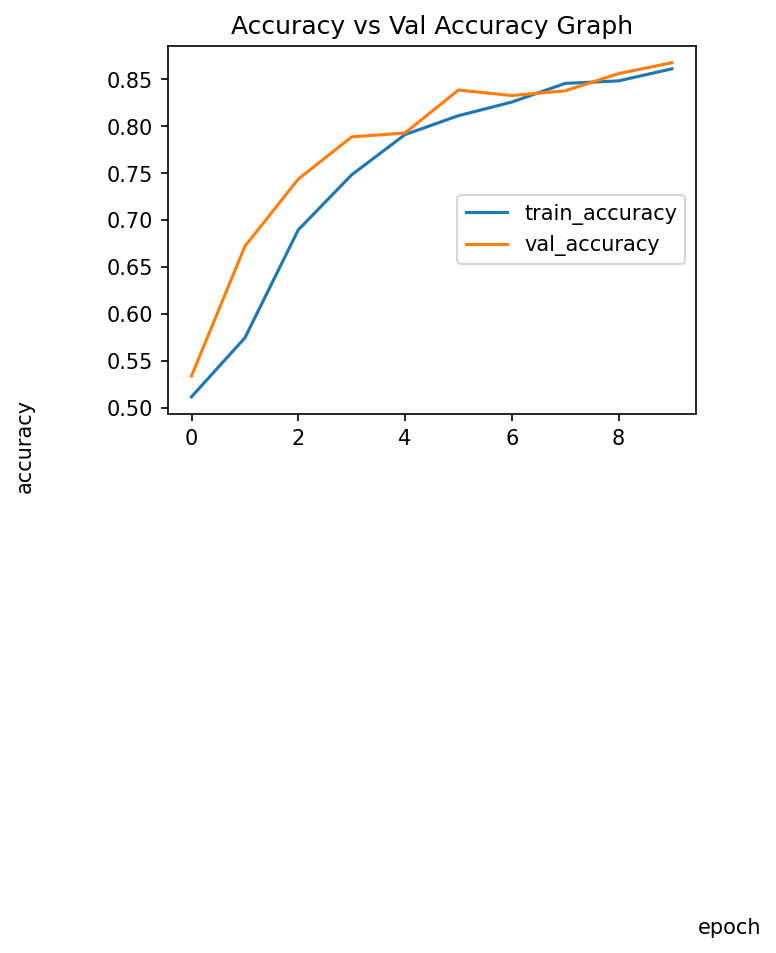

In [21]:
# Call the accuracy_graph function to visualize training and validation accuracy
accuracy_graph("Accuracy vs Val Accuracy Graph", result)


## Model Evaluation

In [22]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):  
    # Display the confusion matrix using an image plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set tick marks and labels for axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    # Determine threshold for text color
    thresh = cm.max() / 2.
    
    # Display text within cells of confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Set labels for axes and adjust layout
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [23]:
# Define the plot_confusion_matrix function
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    # Display the confusion matrix using an image plot
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    # Set tick marks and labels for axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Normalize the confusion matrix if required
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
    
    print(cm)
    
    # Determine threshold for text color
    thresh = cm.max() / 2.
    
    # Display text within cells of confusion matrix
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    
    # Set labels for axes and adjust layout
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Make predictions using the trained model
pred_custom = model.predict(x=val_ds, verbose=0)
pred_custom = np.argmax(pred_custom, axis=1)


In [24]:
# Get the class labels from the training data generator
labels = list(train_ds.class_indices.keys())

Confusion matrix, without normalization
[[209   0  19   2   0   3   1   0   0   0]
 [ 11  18   9   2   0   8   1   0   0   0]
 [ 30   1 601   5   0   4   0   0   0   0]
 [  3   4  10  23   2   0   0   0   0   0]
 [  4   0   2   5  15   0   0   0   0   0]
 [  3   1   2   0   0  87   0   0   0   0]
 [  1   0   0   0   0   0  42   0   4   2]
 [ 10   0   1   0   0   0   0   8   0   0]
 [  2   0   0   0   0   0   0   0  15   2]
 [  2   0   1   0   0   1   0   1   3  21]]


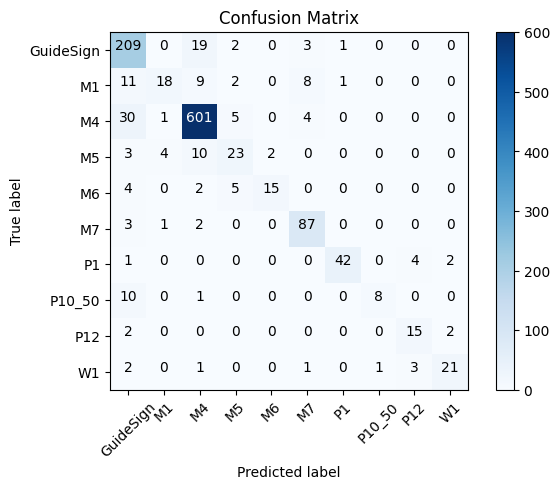

In [25]:
# Compute the confusion matrix using true classes and predicted classes
custom_confusion_matrix = confusion_matrix(val_ds.classes, pred_custom)

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(cm=custom_confusion_matrix, classes=labels)

# CNN Models




### VGG16

In [26]:
# Load the VGG16 model with pretrained weights and exclude the fully connected layers
vgg16 = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=[height,width, 3]
)

# Build a custom classification head on top of VGG16 base
x = vgg16.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(128)(x)
x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
x = tf.keras.layers.GaussianDropout(0.4)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax", dtype='float32')(x)

# Create the final model by combining VGG16 base and custom classification head
vgg_model = tf.keras.Model(vgg16.input, outputs)
vgg_model.summary()


58889256/58889256 [==============================] - 5s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

In [27]:
# Define the optimizer
optimizer = tf.keras.optimizers.Adam(lr=1e-4)

# Define the loss function
loss = tf.keras.losses.CategoricalCrossentropy()

# Define the metrics to be tracked during training
metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
]

# Compile the VGG model with optimizer, loss, and metrics
vgg_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [28]:
# Define the path to save the best model checkpoint
cpk_path = './best_model.h5'

# Define ModelCheckpoint callback to save the best model
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=cpk_path,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Define ReduceLROnPlateau callback to adjust learning rate on plateau
reducelr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_categorical_accuracy',
    mode='max',
    factor=0.1,
    patience=3,
    verbose=0
)

# Define EarlyStopping callback to stop training early if no improvement
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_categorical_accuracy',
    mode='max',
    patience=10,
    verbose=1
)

# Create a list of callbacks to be used during training
callbacks = [checkpoint, reducelr, earlystop]


In [29]:
EPOCHS= 15
VERBOSE =1
    
vgg_model_history = vgg_model.fit(train_ds, 
                        epochs=EPOCHS,
                        callbacks=callbacks,
                        validation_data = val_ds,
                        verbose=VERBOSE)

Epoch 1/15
151/151 [==============================] - ETA: 0s - loss: 1.5314 - categorical_accuracy: 0.5503
Epoch 1: val_categorical_accuracy improved from -inf to 0.62365, saving model to .\best_model.h5
151/151 [==============================] - 444s 3s/step - loss: 1.5314 - categorical_accuracy: 0.5503 - val_loss: 1.1395 - val_categorical_accuracy: 0.6236 - lr: 0.0010
Epoch 2/15
151/151 [==============================] - ETA: 0s - loss: 1.0934 - categorical_accuracy: 0.6417
Epoch 2: val_categorical_accuracy improved from 0.62365 to 0.69359, saving model to .\best_model.h5
151/151 [==============================] - 420s 3s/step - loss: 1.0934 - categorical_accuracy: 0.6417 - val_loss: 0.8941 - val_categorical_accuracy: 0.6936 - lr: 0.0010
Epoch 3/15
151/151 [==============================] - ETA: 0s - loss: 1.0892 - categorical_accuracy: 0.6334
Epoch 3: val_categorical_accuracy did not improve from 0.69359
151/151 [==============================] - 442s 3s/step - loss: 1.0892 - categ

## Model Evaluation and Visualisation

In [30]:
# Evaluate the VGG model on the validation dataset
evaluation_results = vgg_model.evaluate(val_ds)

38/38 [==============================] - 23s 602ms/step - loss: 0.3790 - categorical_accuracy: 0.8718


Confusion matrix, without normalization
[[211   1   8   8   1   2   1   0   2   0]
 [  4  24   5   4  10   2   0   0   0   0]
 [ 10  15 602   9   3   1   0   0   1   0]
 [  7   4   2  23   6   0   0   0   0   0]
 [  4   0   0  18   2   2   0   0   0   0]
 [  0   3   0   0   0  87   0   0   0   3]
 [  2   0   0   0   0   0  45   0   1   1]
 [  0   0   0   0   0   0   0   0   0  19]
 [  0   0   0   0   0   0   1   0  15   3]
 [  1   0   0   0   0   3   0   0   2  23]]


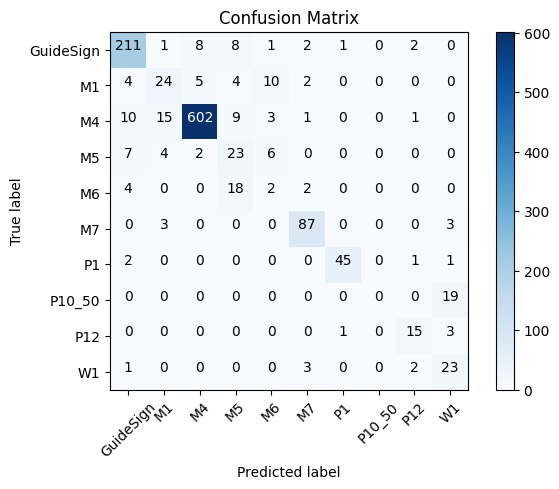

In [31]:
# Make predictions using the trained VGG model on the validation dataset
pred_vgg16 = vgg_model.predict(x=val_ds, verbose=0)
pred_vgg16 = np.argmax(pred_vgg16, axis=1)

# Compute the confusion matrix using true classes and predicted classes
vgg_confusion_matrix = confusion_matrix(val_ds.classes, pred_vgg16)

# Plot the confusion matrix using the plot_confusion_matrix function
plot_confusion_matrix(cm=vgg_confusion_matrix, classes=labels)

In [32]:
# Generate a classification report based on true classes and predicted classes
report = classification_report(val_ds.classes, pred_vgg16, target_names=labels)

# Print the classification report
print(report)


              precision    recall  f1-score   support

   GuideSign       0.88      0.90      0.89       234
          M1       0.51      0.49      0.50        49
          M4       0.98      0.94      0.96       641
          M5       0.37      0.55      0.44        42
          M6       0.09      0.08      0.08        26
          M7       0.90      0.94      0.92        93
          P1       0.96      0.92      0.94        49
      P10_50       0.00      0.00      0.00        19
         P12       0.71      0.79      0.75        19
          W1       0.47      0.79      0.59        29

    accuracy                           0.86      1201
   macro avg       0.59      0.64      0.61      1201
weighted avg       0.86      0.86      0.86      1201



## ResNet152V2

In [33]:
# Load the ResNet152V2 model with pretrained weights
resnet = ResNet152V2(
    include_top=False,
    weights='imagenet',
    pooling='avg',
    input_shape=(32, 32, 3)
)

# Freeze the layers of the pre-trained model
for layer in resnet.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = Flatten()(resnet.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)


234545216/234545216 [==============================] - 10s 0us/step


In [34]:
# Create the final model by specifying inputs and outputs
resnetModel = Model(inputs=resnet.input, outputs=output)

## Call Backs

In [36]:
# Define the path to save the best model checkpoint
checkpoint_path = "./resnet_best_fit.h5"

# Define ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

# Create a list of custom callbacks to be used during training
custom_callbacks = [checkpoint]

In [39]:
# Compile the resnetModel with optimizer, loss, and metrics
resnetModel.compile(optimizer=Adam(lr=0.00001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

# Train the resnetModel using the training and validation datasets
resnet_result = resnetModel.fit(train_ds,
                                epochs=15,
                                validation_data=val_ds,
                                callbacks=custom_callbacks)



Epoch 1/15
151/151 [==============================] - ETA: 0s - loss: 2.1480 - accuracy: 0.3071
Epoch 1: val_accuracy improved from -inf to 0.53372, saving model to .\resnet_best_fit.h5
151/151 [==============================] - 122s 733ms/step - loss: 2.1480 - accuracy: 0.3071 - val_loss: 1.8221 - val_accuracy: 0.5337
Epoch 2/15
151/151 [==============================] - ETA: 0s - loss: 1.8502 - accuracy: 0.5271
Epoch 2: val_accuracy improved from 0.53372 to 0.53539, saving model to .\resnet_best_fit.h5
151/151 [==============================] - 56s 369ms/step - loss: 1.8502 - accuracy: 0.5271 - val_loss: 1.6730 - val_accuracy: 0.5354
Epoch 3/15
151/151 [==============================] - ETA: 0s - loss: 1.7151 - accuracy: 0.5447
Epoch 3: val_accuracy improved from 0.53539 to 0.54205, saving model to .\resnet_best_fit.h5
151/151 [==============================] - 56s 373ms/step - loss: 1.7151 - accuracy: 0.5447 - val_loss: 1.5601 - val_accuracy: 0.5420
Epoch 4/15
151/151 [=============

In [40]:
# Evaluate the resnetModel on the training dataset
train_evaluation = resnetModel.evaluate(train_ds)

151/151 [==============================] - 45s 297ms/step - loss: 0.9662 - accuracy: 0.6826


Confusion matrix, without normalization
[[101   0 133   0   0   0   0   0   0   0]
 [  0   0  47   0   0   0   2   0   0   0]
 [ 25   0 615   0   0   1   0   0   0   0]
 [  7   0  31   3   0   0   1   0   0   0]
 [ 18   0   5   0   0   0   3   0   0   0]
 [  1   0  52   0   0  38   1   0   0   1]
 [  2   0   8   0   0   0  37   2   0   0]
 [  0   0   1   0   0   0   3  15   0   0]
 [  3   0   7   0   0   1   3   2   1   2]
 [  2   0   8   0   0   5   1   0   0  13]]


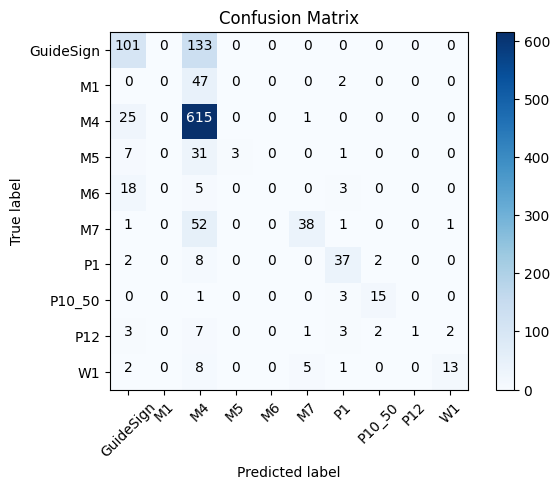

In [41]:
# Predict class probabilities for validation dataset using resnetModel
pred_resnet = resnetModel.predict(x=val_ds, verbose=0)

# Convert predicted probabilities to class labels
pred_resnet = np.argmax(pred_resnet, axis=1)

# Compute the confusion matrix for the validation predictions
resnet_confusion_matrix = confusion_matrix(val_ds.classes, pred_resnet)

# Plot the confusion matrix using the defined plot_confusion_matrix function
plot_confusion_matrix(cm=resnet_confusion_matrix, classes=labels)

In [42]:
# Print the classification report
print(classification_report(val_ds.classes, pred_resnet, target_names=labels))

              precision    recall  f1-score   support

   GuideSign       0.64      0.43      0.51       234
          M1       0.00      0.00      0.00        49
          M4       0.68      0.96      0.79       641
          M5       1.00      0.07      0.13        42
          M6       0.00      0.00      0.00        26
          M7       0.84      0.41      0.55        93
          P1       0.73      0.76      0.74        49
      P10_50       0.79      0.79      0.79        19
         P12       1.00      0.05      0.10        19
          W1       0.81      0.45      0.58        29

    accuracy                           0.69      1201
   macro avg       0.65      0.39      0.42      1201
weighted avg       0.66      0.69      0.63      1201



## Visualisation

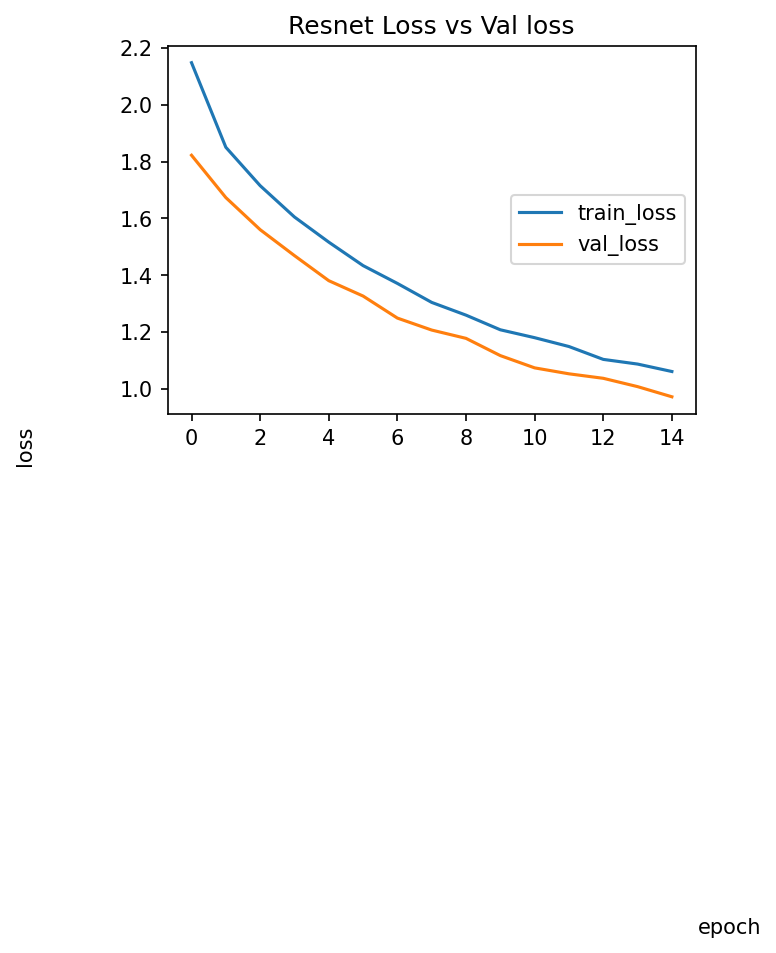

In [43]:
# Call the loss_graph function to plot training and validation loss
loss_graph("Resnet Loss vs Val loss", resnet_result)

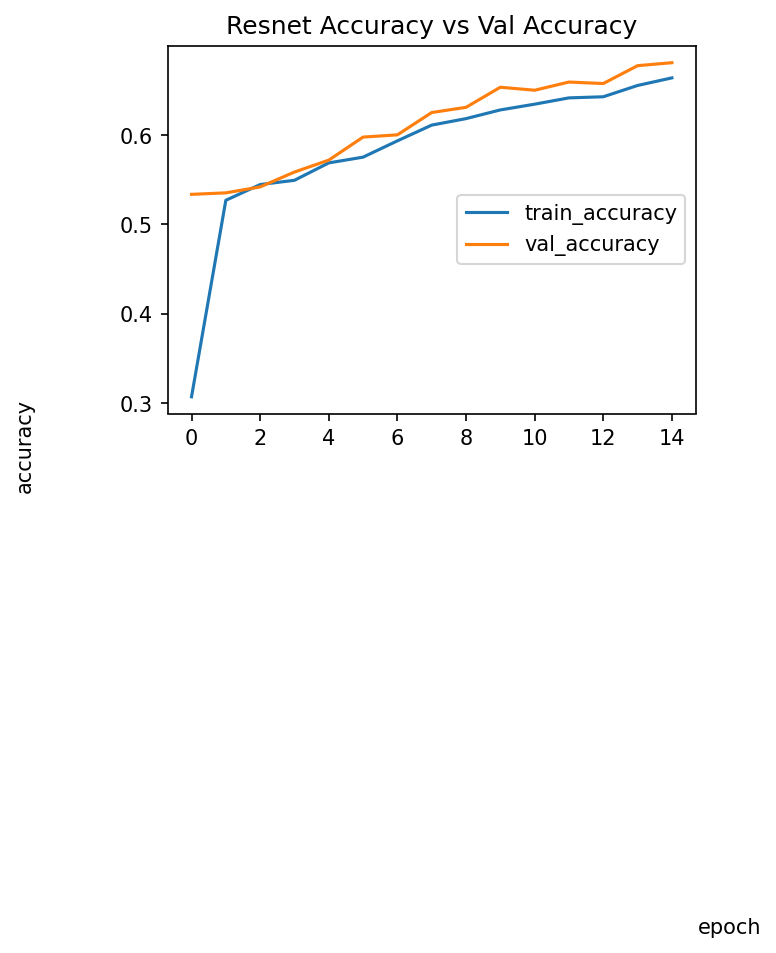

In [44]:
# Call the accuracy_graph function to plot training and validation accuracy
accuracy_graph("Resnet Accuracy vs Val Accuracy", resnet_result)

## DesNet121

In [45]:
# Load the DenseNet121 model with pre-trained weights and customized top layers
denseModel = DenseNet121(
    input_shape=(32, 32, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg'
)

# Freeze the layers of the pre-trained model
for layer in denseModel.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained model
x = Flatten()(denseModel.output)
x = Dropout(0.3)(x)
output = Dense(10, activation='softmax')(x)

29084464/29084464 [==============================] - 2s 0us/step


In [46]:
# Create a new model by specifying input and output layers
denseModelObtained = Model(inputs=denseModel.input, outputs=output)

In [47]:
# Compile the denseModelObtained with optimizer, loss, and metrics
denseModelObtained.compile(optimizer=Adam(lr=0.0003),
                          loss='categorical_crossentropy',
                          metrics=['accuracy'])

# Train the denseModelObtained using the training and validation datasets
denseModelHistory = denseModelObtained.fit(train_ds,
                                           epochs=15,
                                           validation_data=val_ds)

Epoch 1/15
151/151 [==============================] - 44s 209ms/step - loss: 1.4814 - accuracy: 0.5526 - val_loss: 0.7811 - val_accuracy: 0.7469
Epoch 2/15
151/151 [==============================] - 24s 159ms/step - loss: 0.7870 - accuracy: 0.7425 - val_loss: 0.5582 - val_accuracy: 0.8177
Epoch 3/15
151/151 [==============================] - 24s 157ms/step - loss: 0.5987 - accuracy: 0.8014 - val_loss: 0.4712 - val_accuracy: 0.8451
Epoch 4/15
151/151 [==============================] - 23s 155ms/step - loss: 0.5183 - accuracy: 0.8287 - val_loss: 0.4326 - val_accuracy: 0.8551
Epoch 5/15
151/151 [==============================] - 28s 186ms/step - loss: 0.4700 - accuracy: 0.8416 - val_loss: 0.3779 - val_accuracy: 0.8726
Epoch 6/15
151/151 [==============================] - 28s 183ms/step - loss: 0.4229 - accuracy: 0.8609 - val_loss: 0.3637 - val_accuracy: 0.8851
Epoch 7/15
151/151 [==============================] - 23s 149ms/step - loss: 0.4175 - accuracy: 0.8654 - val_loss: 0.3655 - val_ac

In [48]:
# Evaluate the performance of the trained denseModelObtained on the training dataset
denseModelObtained.evaluate(train_ds)

151/151 [==============================] - 22s 148ms/step - loss: 0.2429 - accuracy: 0.9169


[0.2429436892271042, 0.9168567061424255]

Confusion matrix, without normalization
[[205   0  27   1   0   0   0   0   0   1]
 [  0  39   8   0   1   0   1   0   0   0]
 [ 24   4 607   4   1   0   1   0   0   0]
 [  6   4  10  19   3   0   0   0   0   0]
 [  3   0   1   0  22   0   0   0   0   0]
 [  1   3   3   0   0  86   0   0   0   0]
 [  0   0   1   0   0   0  45   0   3   0]
 [  0   0   0   0   0   0   0  19   0   0]
 [  0   0   0   0   0   0   0   1  18   0]
 [  2   0   0   0   0   3   0   0   0  24]]


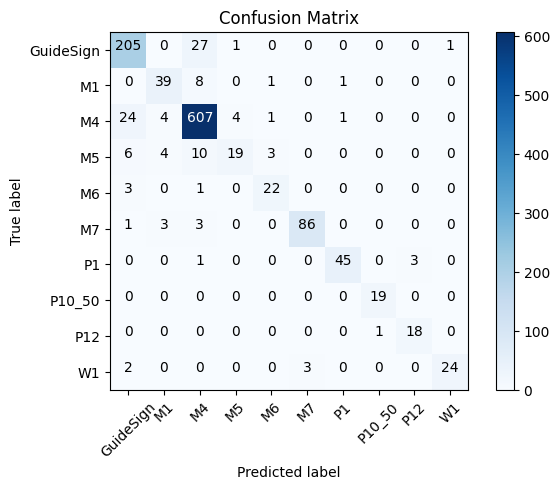

In [49]:
# Predict using the trained denseModelObtained on the validation dataset
pred_dense = denseModelObtained.predict(x=val_ds, verbose=0)

# Convert predicted probabilities to predicted class labels using argmax
pred_dense = np.argmax(pred_dense, axis=1)

# Calculate the confusion matrix for the denseModelObtained predictions on validation data
dense_confusion_matrix = confusion_matrix(val_ds.classes, pred_dense)

# Plot the confusion matrix
plot_confusion_matrix(cm=dense_confusion_matrix, classes=labels)


In [50]:
# Generate a classification report for the denseModelObtained predictions on validation data
print(classification_report(val_ds.classes, pred_dense, target_names=labels))

              precision    recall  f1-score   support

   GuideSign       0.85      0.88      0.86       234
          M1       0.78      0.80      0.79        49
          M4       0.92      0.95      0.94       641
          M5       0.79      0.45      0.58        42
          M6       0.81      0.85      0.83        26
          M7       0.97      0.92      0.95        93
          P1       0.96      0.92      0.94        49
      P10_50       0.95      1.00      0.97        19
         P12       0.86      0.95      0.90        19
          W1       0.96      0.83      0.89        29

    accuracy                           0.90      1201
   macro avg       0.89      0.85      0.86      1201
weighted avg       0.90      0.90      0.90      1201



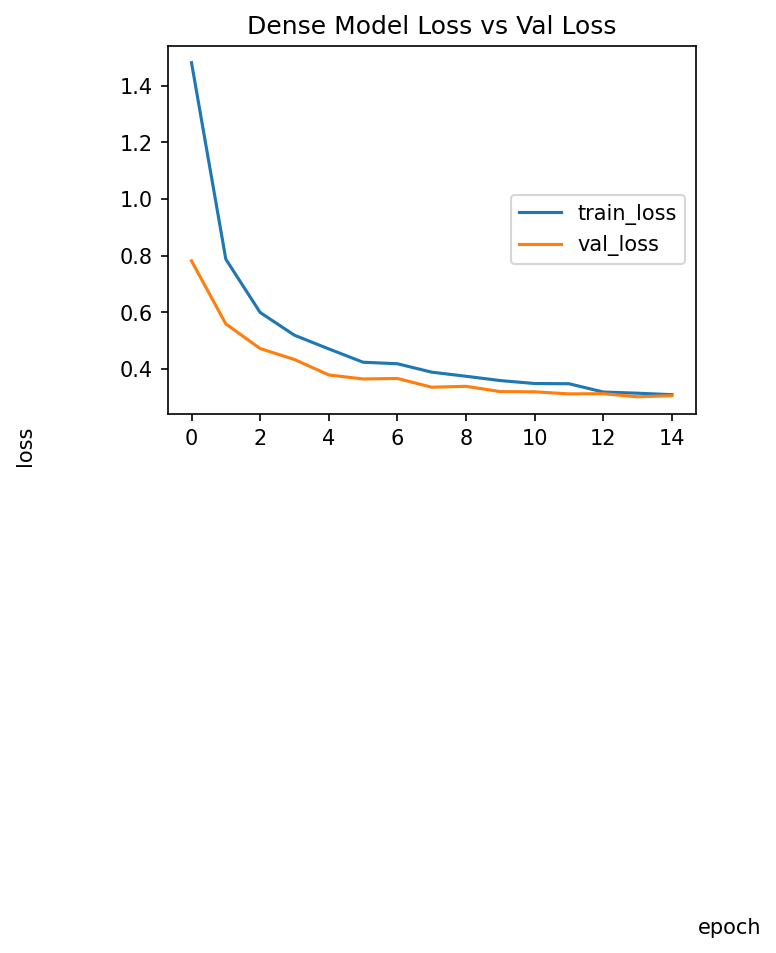

In [51]:
# Plot the training and validation loss over epochs for the denseModelObtained
loss_graph("Dense Model Loss vs Val Loss", denseModelHistory)

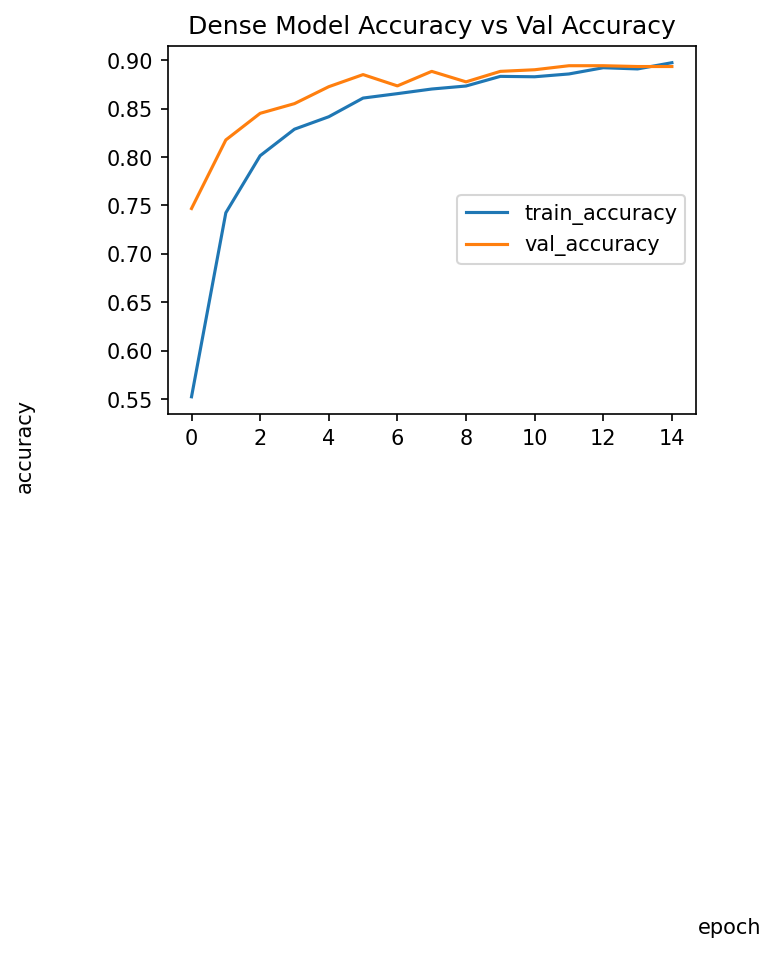

In [52]:
# Plot the training and validation accuracy over epochs for the denseModelObtained
accuracy_graph("Dense Model Accuracy vs Val Accuracy", denseModelHistory)